In [978]:
import torch.nn as nn
import os

In [979]:
print(os.getcwd())

/Users/aungmyinmoe/Documents/NUS-ISS GDipSA/SA60 Materials/SA4110 Machine Learning Applications/CA/Fruit Classification


In [980]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 3
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        # self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        # self.layer5 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h



In [981]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                            stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                            stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                            stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [982]:
from collections import namedtuple

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet18_config = ResNetConfig(block = BasicBlock,
                            n_blocks = [2,2,2],
                            channels = [64, 256, 512])

In [984]:
import torch.optim as optim
import torch

# instantiate the model, define the loss function and optimizer
model = ResNet(resnet18_config, output_dim=4)  # Use your ResNet config and set output_dim to number of classes
# class_weights = torch.tensor([1.0, 1.2, 1.3, 2.5])  # Example: double weight for mixed fruits
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002) # use Adam algo to optimize gradient descend

In [985]:
import os
import numpy as np


#print(os.getcwd()) # find out current working directory in notebook

# prepare all the image file paths and labels
def load_filepaths(target_dir): 
    paths = []
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")
    files = os.listdir(target_dir)
    for file in files:
        if file.endswith(valid_extensions):
            paths.append(f"{target_dir}/{file}")    # list all file names in the folder
    return paths

def prepare_data(target_dir):
    filepaths = []
    labels = []

    for i in range(4):
        fpaths = load_filepaths(target_dir + str(i))
        labels += [i] * len(fpaths)
        filepaths += fpaths # += add elements individually. append() will add the entire list

    return np.array(filepaths), torch.tensor(labels)

dir_train = "train/"
filepaths, labels = prepare_data(dir_train)

In [ ]:
from torchvision import transforms
from PIL import Image

pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

# prepare to load images when testing
def load_images(filepaths):
    # Instantiate class to resize and transform image to tensor
    transform = transforms.Compose([
        transforms.Resize(pretrained_size),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomCrop(pretrained_size, padding = 10),
        transforms.ToTensor(),
        transforms.Normalize(mean = pretrained_means, 
                            std = pretrained_stds)
    ])

    tensor = None

    # List all files in the directory
    for item in filepaths:
        image = Image.open(item).convert("RGB")     # force 3 channels
        # print(f"image size = {image.size}")

        # transforms.ToTensor() performs transformations on images
        # values of img_tensor are in the range of [0.0, 1.0]
        img_tensor = transform(image) # convert into pytorch's tensor to work with
        # print(f"img_tensor.shape = {img_tensor.shape}")
        #input()

        if tensor is None:
            # size: [1,1,28,28]
            tensor = img_tensor.unsqueeze(0) # add a new dimension at specified index. in this case, added dimension is for batch dimension
        else:
            # concatenate becomes [2,1,28,28], [3,1,28,28], [4,1,28,28] ...
            # dim=0 concatenates along the axis=0 (row-wise)
            tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

    return tensor

In [ ]:
# prepare to load images when training
def load_test_images(filepaths):
    # Instantiate class to resize and transform image to tensor
    transform = transforms.Compose([
        transforms.Resize((pretrained_size, pretrained_size)),
        # transforms.CenterCrop(pretrained_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = pretrained_means, 
                            std = pretrained_stds)
    ])

    tensor = None

    # List all files in the directory
    for item in filepaths:
        image = Image.open(item).convert("RGB")     # force 3 channels
        img_tensor = transform(image) # convert into pytorch's tensor to work with


        if tensor is None:
            # size: [1,1,28,28]
            tensor = img_tensor.unsqueeze(0) # add a new dimension at specified index. in this case, added dimension is for batch dimension
        else:
            # concatenate becomes [2,1,28,28], [3,1,28,28], [4,1,28,28] ...
            # dim=0 concatenates along the axis=0 (row-wise)
            tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

    return tensor

In [988]:
from sklearn.model_selection import train_test_split

# Split filepaths and labels into train and validation sets (88% train, 12% val)
train_filepaths, val_filepaths, train_labels, val_labels = train_test_split(
    filepaths, labels, test_size=0.1, stratify=labels, random_state=42
)

print(f"Train samples: {len(train_filepaths)}, Validation samples: {len(val_filepaths)}")

Train samples: 565, Validation samples: 63


In [989]:
# Training loop with validation
n_epochs = 25
batch_size = 64
history = { "loss": [], "accuracy": [], "val_loss": [], "val_accuracy": [] }

for epoch in range(n_epochs):
    model.train()
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(train_filepaths)
    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
        indices = permutation[i : i+batch_size]
        batch_inputs = load_images(train_filepaths[indices])
        batch_labels = train_labels[indices]
        outputs, _ = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        history["loss"].append(loss.item())
        run_loss += loss.item() * len(batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, dim=1)
        samples_trained += len(batch_labels)
        correct_preds += torch.sum(preds == batch_labels)
        accuracy = correct_preds / float(samples_trained)
        history["accuracy"].append(accuracy)
    avg_loss = run_loss / samples_trained

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_samples = len(val_filepaths)
    with torch.no_grad():
        for i in range(0, val_samples, batch_size):
            batch_inputs = load_test_images(val_filepaths[i : i+batch_size])
            batch_labels = val_labels[i : i+batch_size]
            outputs, _ = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item() * len(batch_labels)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, dim=1)
            val_correct += torch.sum(preds == batch_labels)
    avg_val_loss = val_loss / val_samples
    val_accuracy = val_correct / float(val_samples)
    # Early stopping condition
    if val_accuracy >= 0.95:  # set your desired threshold here
        print(f"Early stopping: Validation accuracy reached {val_accuracy:.5f} at epoch {epoch+1}")
        break
    history["val_loss"].append(avg_val_loss)
    history["val_accuracy"].append(val_accuracy)
    print(f"Epoch {epoch+1}: Train Loss={avg_loss:.5f}, Train Acc={accuracy:.5f}, Val Loss={avg_val_loss:.5f}, Val Acc={val_accuracy:.5f}")

/opt/anaconda3/envs/mlaenv/lib/python3.9/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1: Train Loss=0.86793, Train Acc=0.65487, Val Loss=1.23754, Val Acc=0.38095
Epoch 2: Train Loss=0.54182, Train Acc=0.80708, Val Loss=1.02468, Val Acc=0.58730
Epoch 3: Train Loss=0.45844, Train Acc=0.85841, Val Loss=0.52211, Val Acc=0.84127
Epoch 4: Train Loss=0.40426, Train Acc=0.85487, Val Loss=0.47718, Val Acc=0.84127
Epoch 5: Train Loss=0.30882, Train Acc=0.90619, Val Loss=0.42845, Val Acc=0.82540
Epoch 6: Train Loss=0.28939, Train Acc=0.90973, Val Loss=0.39677, Val Acc=0.79365
Epoch 7: Train Loss=0.26176, Train Acc=0.90442, Val Loss=0.36177, Val Acc=0.84127
Epoch 8: Train Loss=0.25188, Train Acc=0.91504, Val Loss=0.47084, Val Acc=0.84127
Epoch 9: Train Loss=0.31335, Train Acc=0.89558, Val Loss=0.24688, Val Acc=0.88889
Epoch 10: Train Loss=0.40165, Train Acc=0.88142, Val Loss=0.27672, Val Acc=0.87302
Epoch 11: Train Loss=0.32349, Train Acc=0.88319, Val Loss=0.46397, Val Acc=0.84127
Epoch 12: Train Loss=0.26766, Train Acc=0.90619, Val Loss=0.39204, Val Acc=0.85714
Epoch 13: Tra

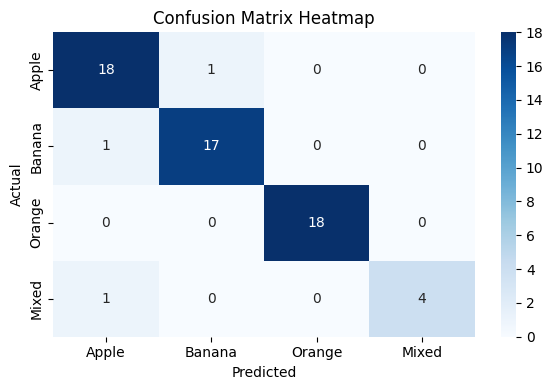

Overall Accuracy: 0.95000
Apple Accuracy: 0.94737
Banana Accuracy: 0.94444
Orange Accuracy: 1.00000
Mixed Accuracy: 0.80000


In [990]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Test the model
dir_test = "test/"
filepaths, labels = prepare_data(dir_test)

batch_size = 60
total_samples = len(filepaths)

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for i in range(0, total_samples, batch_size):
        batch_inputs = load_test_images(filepaths[i: i + batch_size])
        batch_labels = labels[i: i + batch_size]

        outputs, _ = model(batch_inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, dim=1)

        all_preds.extend(preds.numpy())
        all_labels.extend(batch_labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Class labels
class_names = ['Apple', 'Banana', 'Orange', 'Mixed']

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

# Compute per-class accuracy
cm_tensor = torch.tensor(cm)
class_totals = cm_tensor.sum(dim=1)
correct_per_class = cm_tensor.diag()
class_accuracies = correct_per_class / class_totals

# Print results
total_correct = cm_tensor.diag().sum().item()
overall_accuracy = total_correct / total_samples

print(f"Overall Accuracy: {overall_accuracy:.5f}")
for i, cls in enumerate(class_names):
    print(f"{cls} Accuracy: {class_accuracies[i]:.5f}")

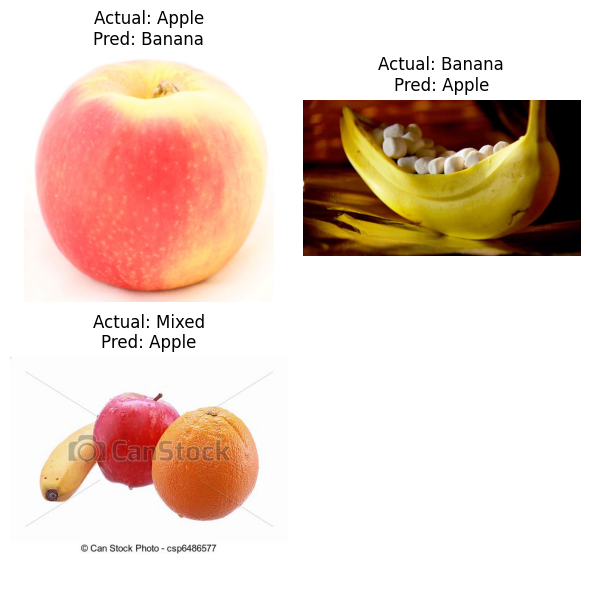

In [991]:
from PIL import Image
import math

# Show up to 10 misclassified images in a square grid layout
max_to_show = 15
misclassified = []

for idx, (pred, actual) in enumerate(zip(all_preds, all_labels)):
    if pred != actual:
        img_path = filepaths[idx]
        misclassified.append((img_path, actual, pred))
        if len(misclassified) >= max_to_show:
            break

if len(misclassified) == 0:
    print("No misclassified images found.")
else:
    n = len(misclassified)
    grid_size = math.ceil(math.sqrt(n))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(3*grid_size, 3*grid_size))
    axes = axes.flatten()
    for i, (img_path, actual, pred) in enumerate(misclassified):
        img = Image.open(img_path).convert("RGB")
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Actual: {class_names[actual]}\nPred: {class_names[pred]}")
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

In [992]:
# torch.save(model, '90_accuracy_less_complex.pth')

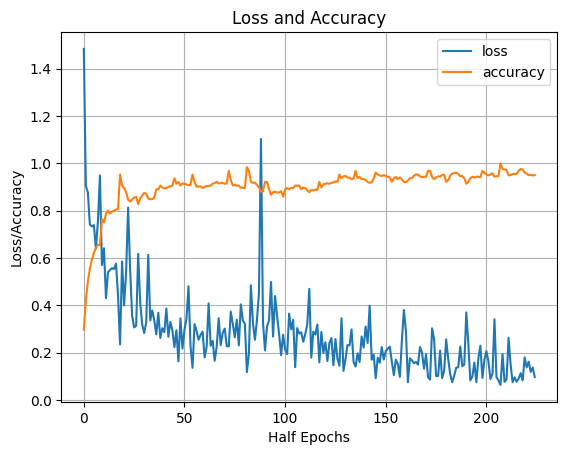

In [993]:
import matplotlib.pyplot as plt
import numpy as np

half_epochs = np.arange(len(history["loss"]))

# plot loss and accuracy
plt.plot(half_epochs, history["loss"], label="loss")
plt.plot(half_epochs, history["accuracy"], label="accuracy")
plt.xlabel("Half Epochs")
plt.ylabel("Loss/Accuracy")
plt.title("Loss and Accuracy")
plt.legend()
plt.grid()
plt.show()